In [1]:
suppressMessages(library(scDesign3))
suppressMessages(library(scales))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(cowplot))
suppressMessages(library(Seurat))
suppressMessages(library(SingleCellExperiment))

source("../utils/helper.R")

# set random seed
set.seed(2024)

In [2]:
output_dir <- '../../results/01_generate_simulate_data/23_slide_seqv2_Mouse_Cerebellum'

if(!dir.exists(output_dir)){
    dir.create(output_dir, recursive = TRUE)
}

In [3]:
adata <- read_h5ad('../../results/00_prepare_reference_data/23_slide_seqv2_Mouse_Cerebellum.h5ad')

In [4]:
counts <- t(as.matrix(adata$layers[['counts']]))
colnames(counts) <- adata$obs_names
rownames(counts) <- adata$var_names
    
df_loc <- as.data.frame(adata$obsm[['spatial']])
colnames(df_loc) <- c("spatial1", "spatial2")
rownames(df_loc) <- adata$obs_names

In [5]:
ref_sce <- SingleCellExperiment(list(counts=counts), colData=df_loc)

In [6]:
ref_sce

class: SingleCellExperiment 
dim: 10 25258 
metadata(0):
assays(1): counts
rownames(10): Ttr Enpp2 ... Pcp4 Calb1
rowData names(0):
colnames(25258): CTTCCATGACATTT TAGCCGGGTCTCTG ... TTGCCCGTCAAACA
  CACCGACTCAGAAA
colData names(2): spatial1 spatial2
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [7]:
plot_exp <- function(sce, gene, pt_size=1){
    df_loc <- colData(sce)[, c("spatial1","spatial2")]
    df_exp <- as.data.frame(counts(sce)[gene, ])
    colnames(df_exp) <- c('exp')
    df_exp$exp <- rescale(log1p(df_exp$exp))
    
    df <- cbind(df_exp, df_loc)
    
    p <- ggplot(data = df, aes(x = spatial1, y = spatial2)) +
    geom_point(aes(color = exp), size = pt_size) +
    scale_colour_gradientn(colors = viridis_pal(option = "magma")(10), limits=c(0, 1)) +
    theme_cowplot() +
    theme(axis.text = element_blank(), axis.ticks = element_blank()) +
    ggtitle(gene)
    
    return(p)
}

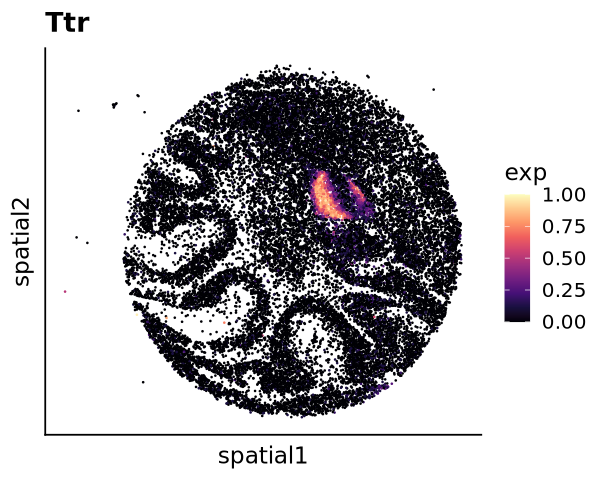

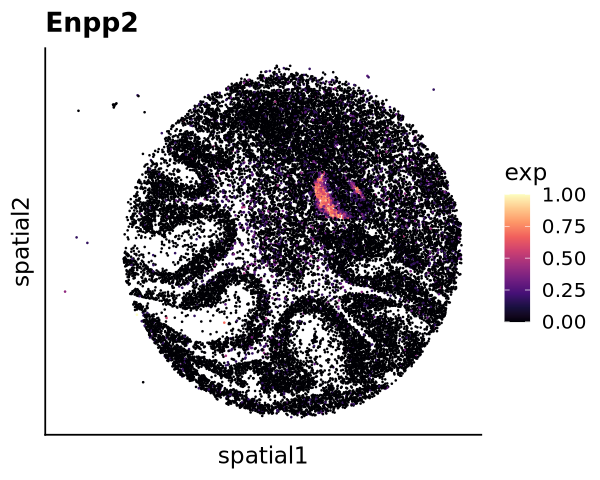

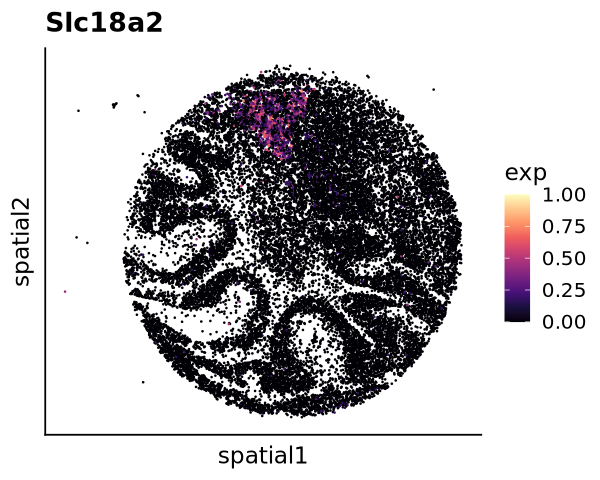

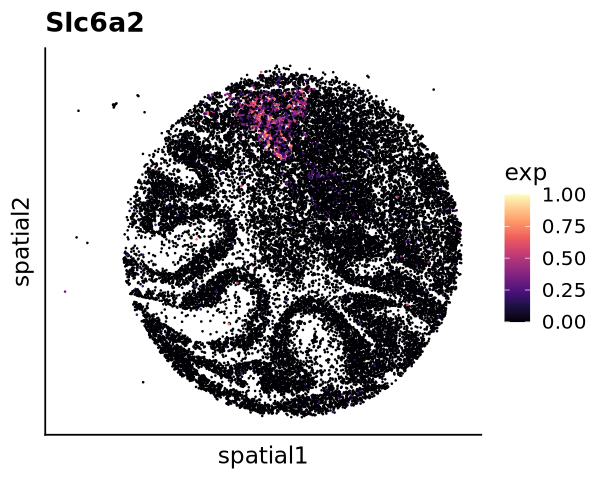

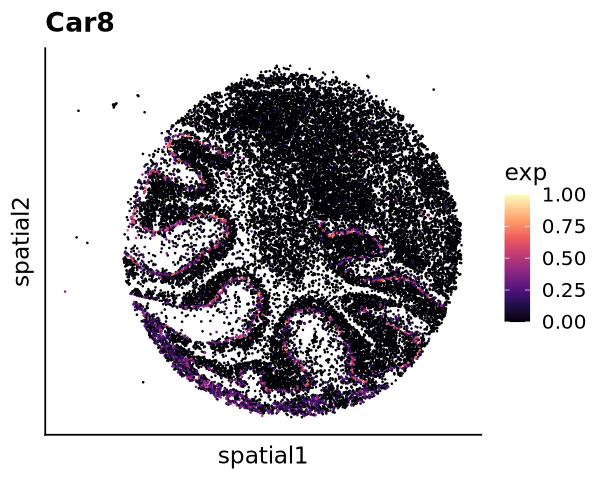

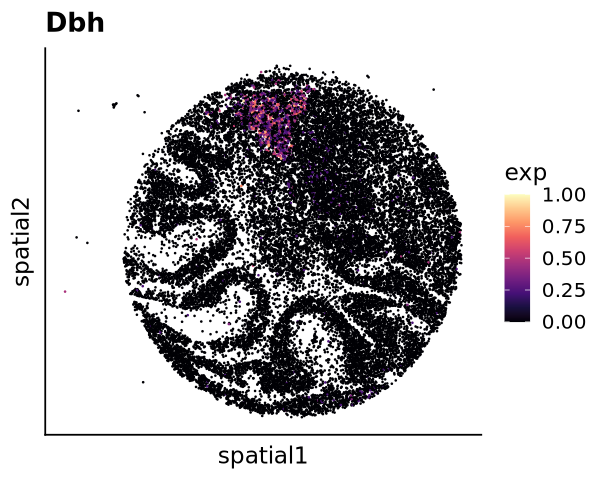

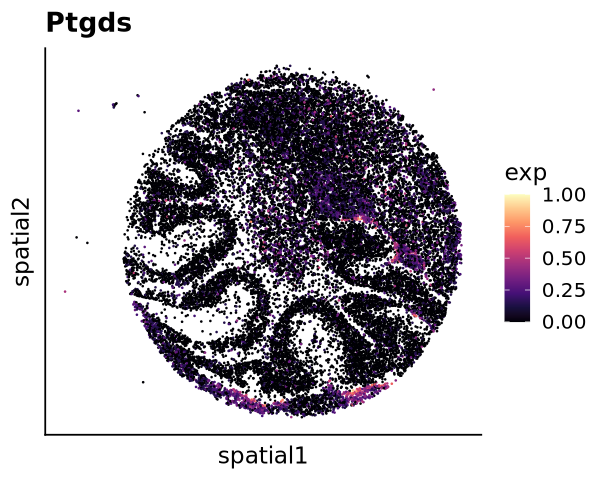

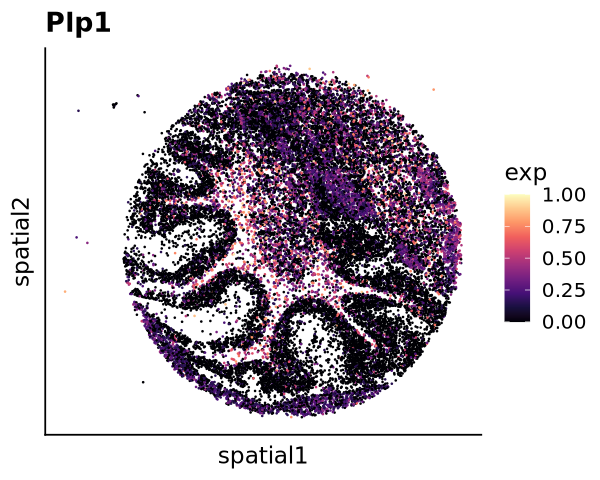

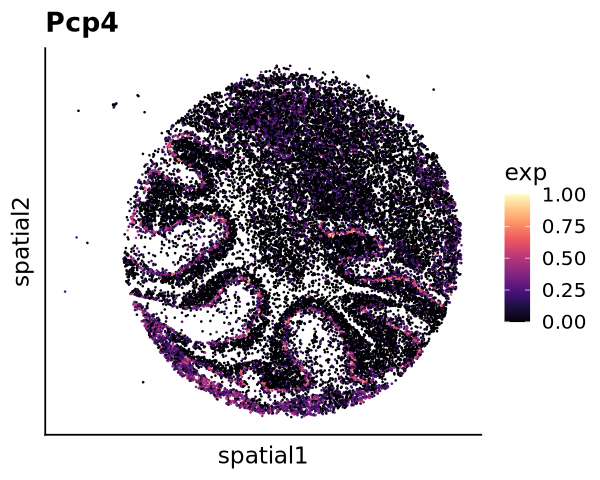

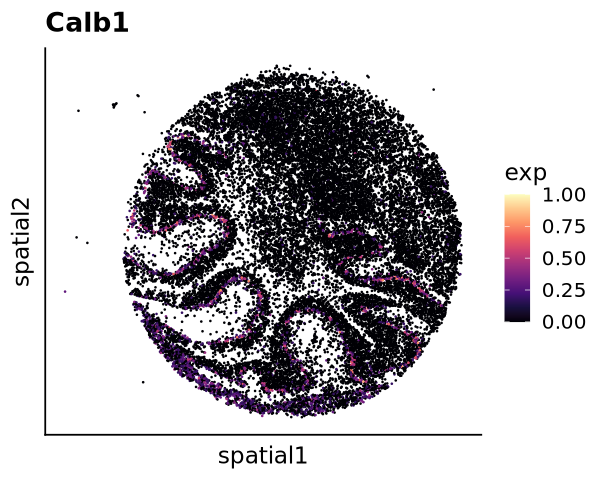

In [8]:
options(repr.plot.height = 4, repr.plot.width = 5)

for(gene in rownames(ref_sce)){
    p <- plot_exp(ref_sce, gene = gene, pt_size = 0.1)
    print(p)
}

In [9]:
# constructs the input data for fit_marginal.
ref_data <- construct_data(
    sce = ref_sce,
    assay_use = "counts",
    celltype = NULL,
    pseudotime = NULL,
    spatial = c("spatial1", "spatial2"),
    other_covariates = NULL,
    corr_by = "1"
)

# fit expression of each gene with GP model
ref_marginal <- fit_marginal(
    data = ref_data,
    predictor = "gene",
    mu_formula = "s(spatial1, spatial2, bs = 'gp', k = 500)", 
    sigma_formula = "1",
    family_use = "nb",
    n_cores = 2,
    usebam = FALSE,
    trace = TRUE
  )

ref_copula <- fit_copula(
    sce = ref_sce,
    assay_use = "counts",
    marginal_list = ref_marginal,
    family_use = "nb",
    copula = "gaussian",
    n_cores = 2,
    input_data = ref_data$dat
)

ref_para <- extract_para(
    sce = ref_sce,
    marginal_list = ref_marginal,
    n_cores = 5,
    family_use = "nb",
    new_covariate = ref_data$newCovariate,
    data = ref_data$dat
  )

Convert Residuals to Multivariate Gaussian

Converting End

Copula group 1 starts



In [10]:
sim_count <- simu_new(
        sce = ref_sce,
        mean_mat = ref_para$mean_mat,
        sigma_mat = ref_para$sigma_mat,
        zero_mat = ref_para$zero_mat,
        quantile_mat = NULL,
        copula_list = ref_copula$copula_list,
        n_cores = 5,
        family_use = "nb",
        input_data = ref_data$dat,
        new_covariate = ref_data$newCovariate,
        important_feature = rep(TRUE, dim(ref_sce)[1]),
        filtered_gene = NULL)

sim_sce <- SingleCellExperiment(list(counts = sim_count), 
                                colData = ref_data$newCovariate)

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts



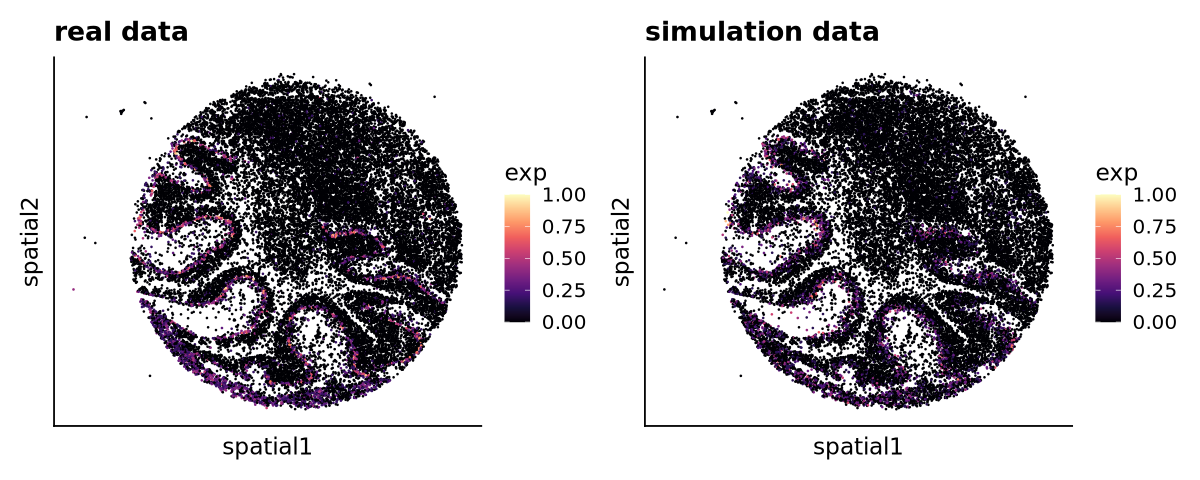

In [11]:
options(repr.plot.height = 4, repr.plot.width = 10)

p1 <- plot_exp(ref_sce, gene='Car8', pt_size = 0.1) + ggtitle("real data")
p2 <- plot_exp(sim_sce, gene='Car8', pt_size = 0.1) + ggtitle("simulation data")

p1 + p2

In [12]:
# generate non-spatially variable mean values with shuffling
shuffle_idx <- sample(nrow(ref_para$mean_mat))
non_de_mat <- ref_para$mean_mat[shuffle_idx, ]

In [13]:
# simulate data with varied spatial variability
count <- lapply(seq(0, 1.0, 0.05), function(alpha){
    sim_count <- simu_new(
        sce = ref_sce,
        mean_mat =  alpha * ref_para$mean_mat + (1 - alpha) * non_de_mat,
        sigma_mat = ref_para$sigma_mat,
        zero_mat = ref_para$zero_mat,
        quantile_mat = NULL,
        copula_list = ref_copula$copula_list,
        n_cores = 5,
        family_use = "nb",
        input_data = ref_data$dat,
        new_covariate = ref_data$newCovariate,
        important_feature = rep(TRUE, dim(ref_sce)[1]),
        filtered_gene = NULL)

    rownames(sim_count) <- paste0(rownames(sim_count), "_", alpha)
    
    return(sim_count)

}) %>% do.call(rbind, .)

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use 

In [14]:
# save simulated data
write.csv(ref_data$newCovariate, file = glue::glue("{output_dir}/location.csv"))
write.csv(count, file = glue::glue('{output_dir}/counts.csv'))